### C247A Project

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [17]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [18]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Preprocessing the Data:

In [4]:
y_train_valid -= 769
y_test -= 769

In [5]:
perm = np.random.permutation(X_train_valid.shape[0])
numTrain = int(0.8*X_train_valid.shape[0])
numVal = X_train_valid.shape[0] - numTrain
Xtrain = X_train_valid[perm[0:numTrain]]
ytrain = y_train_valid[perm[0:numTrain]]
Xval = X_train_valid[perm[numTrain: ]]
yval = y_train_valid[perm[numTrain: ]]

In [44]:
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)

(1692, 22, 1000) (1692,) (423, 22, 1000) (423,)


### Counting the Number of the first object:

In [22]:
count = 0
for i in range(2115):
    if(person_train_valid[i] == 1):
        count += 1
    else:
        count = count

t_count = 0
for j in range(443):
    if(person_test[j] == 1):
        t_count += 1
    else:
        t_count = t_count

print("The number of subject 1 in the validation is:", count)
print("The number of subject 1 in the testing is:", t_count)

The number of subject 1 in the validation is: 236
The number of subject 1 in the testing is: 50


### Convolutional Network:

### Keras Shallow Convolutional Network:

The following model is provided from the jupyter notebook: keras shallow convnet.

In [67]:
def Ksquare(x):
    return K.pow(x, 2)
def Klog(x):
    return K.log(x)

### Add this shit because it doesn't work at first:

In [68]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


In [69]:
inputs = layers.Input(shape=(22, 1000))
r1 = layers.Reshape((1, 22, 1000))(inputs)
c1 = layers.Conv2D(40, (1, 25), strides=1, activation='elu',
                  data_format='channels_first')(r1)
r2 = layers.Reshape((1, 40*22, 976))(c1)
c2 = layers.Conv2D(40, (40*22, 1), strides=1, activation='elu',
                  data_format='channels_first')(r2)
sq1 = layers.Activation(Ksquare)(c2)
r3 = layers.Reshape((1, 40, 976))(sq1)
apool1 = layers.AveragePooling2D((1, 75), strides=(1, 15), 
                                 data_format = 'channels_first')(r3)
log1 = layers.Activation(Klog)(apool1)
f1 = layers.Flatten()(log1)
outputs = layers.Dense(4, activation='softmax')(f1)

### Testing across Subject 1:

In [70]:
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

In [71]:
X1train = Xtrain[:236,:,:]
y1train = ytrain[:236]
X1val=Xval[:50,:,:]
y1val=yval[:50]

loss_hist = model.fit(X1train, y1train, validation_data=(X1val, y1val), epochs=20)

Train on 236 samples, validate on 50 samples
Epoch 1/20
236/236 [==============================] - 7s 29ms/step - loss: 3.1073 - acc: 0.2076 - val_loss: 2.7883 - val_acc: 0.2600
Epoch 2/20
236/236 [==============================] - 5s 21ms/step - loss: 1.8267 - acc: 0.3347 - val_loss: 1.9034 - val_acc: 0.2000
Epoch 3/20
236/236 [==============================] - 5s 20ms/step - loss: 1.4297 - acc: 0.3898 - val_loss: 1.5933 - val_acc: 0.3200
Epoch 4/20
236/236 [==============================] - 5s 20ms/step - loss: 1.2555 - acc: 0.4322 - val_loss: 1.4850 - val_acc: 0.2200
Epoch 5/20
236/236 [==============================] - 5s 20ms/step - loss: 1.1977 - acc: 0.4703 - val_loss: 1.4219 - val_acc: 0.3200
Epoch 6/20
236/236 [==============================] - 5s 20ms/step - loss: 1.0359 - acc: 0.5508 - val_loss: 1.4962 - val_acc: 0.3000
Epoch 7/20
236/236 [==============================] - 5s 20ms/step - loss: 0.9337 - acc: 0.6398 - val_loss: 1.4751 - val_acc: 0.3400
Epoch 8/20
236/236 [====

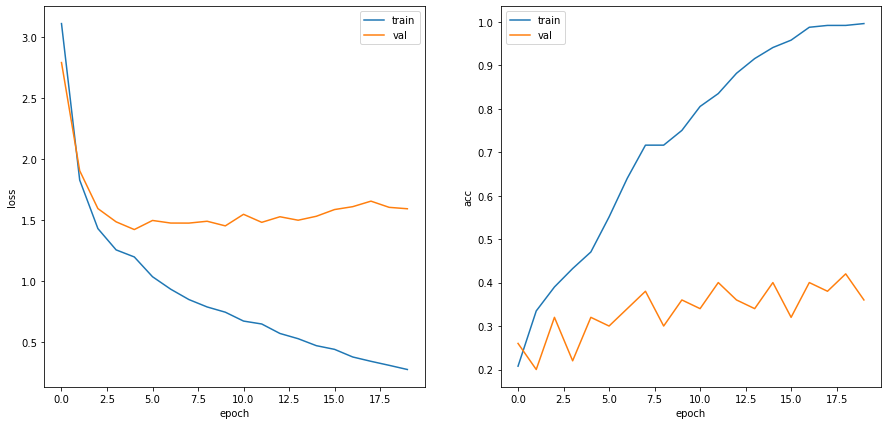

In [72]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

### Testing across All subjects:

In [25]:
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

In [26]:
loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 40)

Train on 1692 samples, validate on 423 samples
Epoch 1/40
1692/1692 [==============================] - 32s 19ms/step - loss: 1.7333 - acc: 0.3067 - val_loss: 1.4516 - val_acc: 0.2861
Epoch 2/40
1692/1692 [==============================] - 32s 19ms/step - loss: 1.2622 - acc: 0.4362 - val_loss: 1.4530 - val_acc: 0.2908
Epoch 3/40
1692/1692 [==============================] - 31s 19ms/step - loss: 1.1590 - acc: 0.4941 - val_loss: 1.3961 - val_acc: 0.3452
Epoch 4/40
1692/1692 [==============================] - 31s 18ms/step - loss: 1.0582 - acc: 0.5431 - val_loss: 1.3228 - val_acc: 0.4066
Epoch 5/40
1692/1692 [==============================] - 32s 19ms/step - loss: 0.9416 - acc: 0.6223 - val_loss: 1.2177 - val_acc: 0.4657
Epoch 6/40
1692/1692 [==============================] - 32s 19ms/step - loss: 0.8356 - acc: 0.6820 - val_loss: 1.2855 - val_acc: 0.4657
Epoch 7/40
1692/1692 [==============================] - 31s 18ms/step - loss: 0.7432 - acc: 0.7157 - val_loss: 1.2588 - val_acc: 0.4752
E

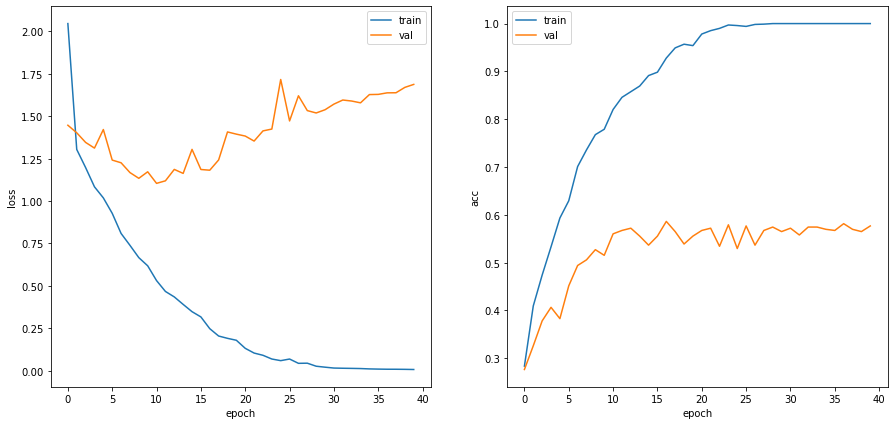

In [23]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

### Modified Version:

In [13]:
inputs = layers.Input(shape=(22, 1000))
r1 = layers.Reshape((1, 22, 1000))(inputs)
c1 = layers.Conv2D(40, (1, 25), strides=1, activation='elu',
                  data_format='channels_first')(r1)
#c1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
   #                                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
      #                                            beta_constraint=None, gamma_constraint=None)(c1)
#c1 = layers.ELU()(c1)
r2 = layers.Reshape((1, 40*22, 976))(c1)
c2 = layers.Conv2D(40, (40*22, 1), strides=1, activation='elu',
                  data_format='channels_first')(r2)
#c2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
   #                                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
    #                                              beta_constraint=None, gamma_constraint=None)(c2)
#c2 = layers.ELU()(c2)
#outputs = c2 + inputs
sq1 = layers.Activation(Ksquare)(c2)
r3 = layers.Reshape((1, 40, 976))(sq1)
apool1 = layers.AveragePooling2D((1, 75), strides=(1, 15), 
                                 data_format = 'channels_first')(r3)
log1 = layers.Activation(Klog)(apool1)
f1 = layers.Flatten()(log1)
outputs = layers.Dense(4, activation='softmax')(f1)

In [21]:
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

In [22]:
loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 40)

Train on 1692 samples, validate on 423 samples
Epoch 1/40
1692/1692 [==============================] - 32s 19ms/step - loss: 2.0452 - acc: 0.2837 - val_loss: 1.4464 - val_acc: 0.2766
Epoch 2/40
1692/1692 [==============================] - 31s 18ms/step - loss: 1.3037 - acc: 0.4096 - val_loss: 1.4019 - val_acc: 0.3262
Epoch 3/40
1692/1692 [==============================] - 32s 19ms/step - loss: 1.1971 - acc: 0.4740 - val_loss: 1.3453 - val_acc: 0.3783
Epoch 4/40
1692/1692 [==============================] - 32s 19ms/step - loss: 1.0836 - acc: 0.5331 - val_loss: 1.3118 - val_acc: 0.4066
Epoch 5/40
1692/1692 [==============================] - 32s 19ms/step - loss: 1.0184 - acc: 0.5934 - val_loss: 1.4211 - val_acc: 0.3830
Epoch 6/40
1692/1692 [==============================] - 31s 19ms/step - loss: 0.9276 - acc: 0.6294 - val_loss: 1.2412 - val_acc: 0.4515
Epoch 7/40
1692/1692 [==============================] - 31s 18ms/step - loss: 0.8090 - acc: 0.7009 - val_loss: 1.2252 - val_acc: 0.4941
E

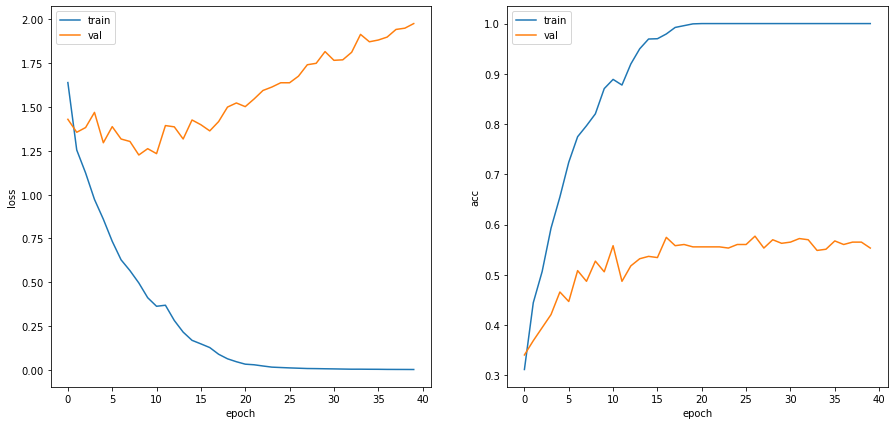

In [19]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

### Filter Bank Common Spatial Pattern:

In [ ]:
print()